In [1]:
using GpABC, DifferentialEquations, Distances, Plots, Distributions


# Deterministic model of three genes interaction network

In this example we are going to perform parameter inference for a deterministic model of three gene interaction, described in (Karlebach & Shamir, 2008). The model is illustrated by the figure below

<img src="threegeneinteractions.png" width="500" height="1000">

Apart from participating in the interactions shown on this diagram, all genes are also activated by the environment and degrade into environment (not shown). Gene 1 is repressed by Gene 3, Gene 2 is activated by Gene 1, and Gene 3 is activated by both Gene 1 and Gene 2.

Using Michaelis-Menten kinetics, we can produce the following system of diferential equations for this system:

$$
\begin{align*}
\frac{dx_1}{dt} &= k_{1,a}\frac{1}{1+k_{3,1} x_3} - k_{1,d} x_1\\
\frac{dx_2}{dt} &= k_{2,a}\frac{k_{1,2} x_1}{1+k_{1,2} x_1} - k_{2,d} x_2\\
\frac{dx_3}{dt} &= k_{3,a}\frac{k_{1,3} x_1 k_{2,3} x_3}{(1+k_{1,3} x_1)(1+k_{2,3} x_2)} - k_{3,d} x_3
\end{align*}
$$

Here, for $i, j \in \{1, 2, 3\}$, $x_i$ denote concentrations of respective genes, as they change with time; $k_{i, a}$ are the rates with which Gene $i$ is activated by the environment; $k_{i, d}$ are the rates with which Gene $i$ degrades into the environment, and k{i, j} is the rate with which Gene $i$ activates or represses Gene $j$.

### References
- Toni, T., Welch, D., Strelkowa, N., Ipsen, A., & Stumpf, M. P. H. (2009). Approximate Bayesian computation scheme for parameter inference and model selection in dynamical systems. *Interface*, (July 2008), 187–202. https://doi.org/10.1098/rsif.2008.0172
- Karlebach, G., & Shamir, R. (2008). Modelling and analysis of gene regulatory networks. *Nature Reviews Molecular Cell Biology*, 9(10), 770–780. https://doi.org/10.1038/nrm2503


# Rejection ABC using `GpABC` - estimating parameters

Let's start by implementing the above system of ODEs in Julia, and setting up some scaffolding for the ABC computations.

In [2]:
#
# ABC settings
#
true_params =  [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]
priors = [Uniform(0.2, 5.), Uniform(0.2, 5.), Uniform(10., 20.),
            Uniform(0.2, 2.), Uniform(0.2, 2.), Uniform(0.2, 2.),
            Uniform(75., 125.),
            Uniform(0.2, 2.), Uniform(0.2, 2.), Uniform(0.2, 2.)]
param_indices = [1,2,3]
priors = priors[param_indices]

#
# ODE solver settings
#
Tspan = (0.0, 10.0)
x0 = [3.0, 2.0, 1.0]
solver = RK4()
saveat = 0.1

#
# Returns the solution to the toy model as solved by DifferentialEquations
#
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1] = par[1]/(1+par[7]*x[3]) - par[4]*x[1]
    dx[2] = par[2]*par[8]*x[1]/(1+par[8]*x[1]) - par[5]*x[2]
    dx[3] = par[3]*par[9]*x[1]*par[10]*x[2]./(1+par[9]*x[1])./(1+par[10]*x[2]) - par[6]*x[3]
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Array{Float64, 2}(Obs)
end

function simulator_function(var_params)
    params = copy(true_params)
    params[param_indices] .= var_params
    GeneReg(params, Tspan, x0, solver, saveat)
end

simulator_function (generic function with 1 method)

## Plot reference data

The reference data is the concentrations over time for the three species. Computed by solving the model with the true parameters.

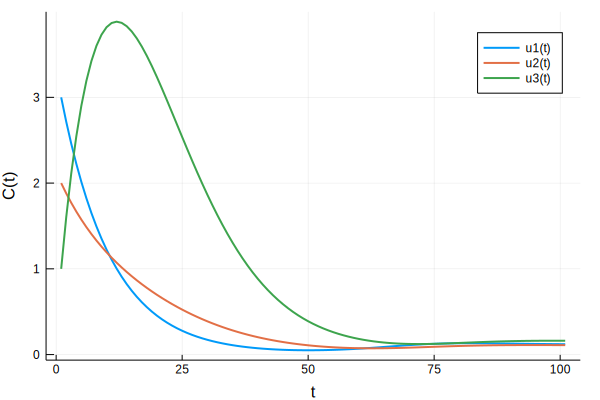

In [3]:
#
# Get reference data and plot it
#
reference_data = simulator_function(true_params[param_indices])
plot(reference_data', xlabel="t", ylabel="C(t)", linewidth=2, labels=["u1(t)", "u2(t)", "u3(t)"])


## Simulation-based rejection ABC

`GpABC.jl` provides two algorithms for rejection ABC: simulation-based and emulation-based. 

Here we begin by demonstrating simulated rejection ABC, by calling `SimulatedABCRejection` function ([docs](https://tanhevg.github.io/GpABC.jl/latest/ref-abc.html)). The simulator function will be called on every step of the  ABC procedure. 

The plot recipe makes it easy to visualise the results. As one can see, after just one iteration of rejection ABC the posteriour population does not highlight the true parameters very well.


┌ Warning: Simulation reached maximum iterations 10000 before finding 1000 particles - will return 176
└ @ GpABC /Users/tanhevg/Desktop/projects/gaussian_processes/GpABC.jl/src/abc/rejection.jl:92


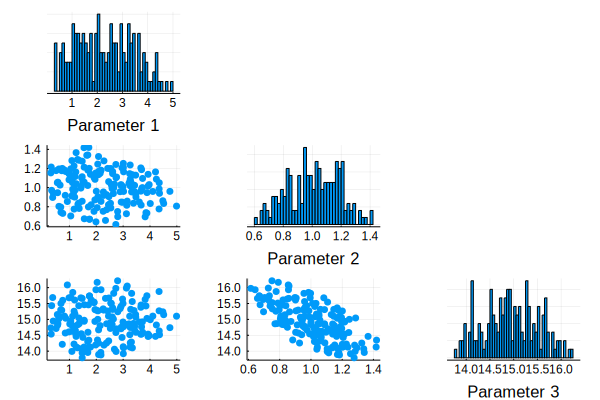

In [4]:
#
# Simulation
#
n_particles = 1000
threshold = 1.0
sim_result = SimulatedABCRejection(reference_data, simulator_function, priors, threshold, n_particles; 
    write_progress=false)
plot(sim_result)

## Emulation-based rejection ABC

This algorithm is similar to simulation-based procedure described above. Here, instead of running the simulation at each step of the ABC, the simulated results are used to train the emulator that outputs the distance from the given point in the parameter space to reference data. These emulated distances are then used in the ABC algorithm.

Arguments of `EmulatedABCRejection` function ([docs](https://tanhevg.github.io/GpABC.jl/latest/ref-abc.html)) are very similar to those of `SimulatedABCRejection`, with the addition of `n_design_points` that controls the number of particles that will be used for simulation and training the emulator.

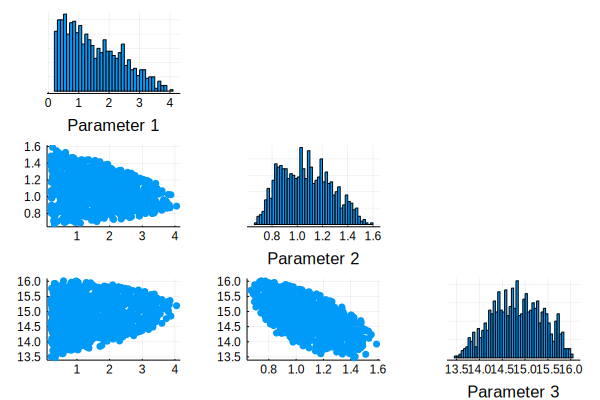

In [5]:
n_design_points = 100
emu_result = EmulatedABCRejection(reference_data, simulator_function, priors, threshold, n_particles, n_design_points; 
    write_progress=false)
plot(emu_result)

# Comparing the resulting posteriors from simulation and emulation

They are similar and both center on the correct parameter values.

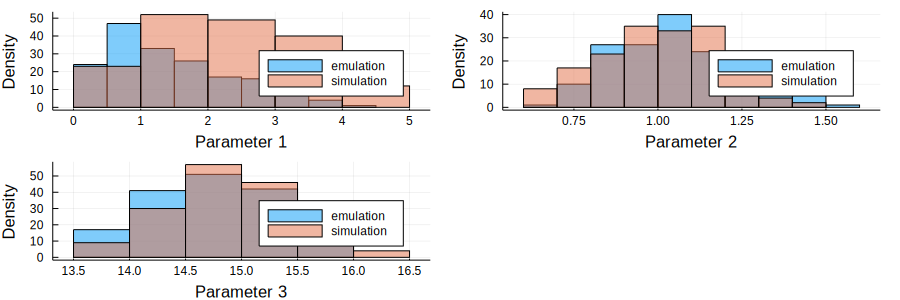

In [6]:
plts = Array{Plots.Plot}(undef, length(priors))
for idx in 1:length(plts)
    min_pop_len = min(size(emu_result.population, 1), size(sim_result.population, 1))
    plts[idx] = histogram([emu_result.population[1:min_pop_len,idx] sim_result.population[1:min_pop_len,idx]], 
        label=["emulation", "simulation"], fillalpha=0.5, xlabel="Parameter $idx", ylabel="Density")
end
plot(plts..., size=(900,300))

# ABC-SMC

In [7]:
#
# ABC-SMC settings
#
threshold_schedule = [3.0, 2.0, 1.0, 0.5, 0.2];

## Simulation-based ABC-SMC

Similarly to rejection ABC, two algorithms are provided for ABC-SMC: simulation and emulation based. Parameters for `SimulatedABCSMC` function ([docs](https://tanhevg.github.io/GpABC.jl/latest/ref-abc.html)) are identical to those of `SimulatedABCRejection`. Lower thresholds allow the SMC algorithm to produce much more accurate results than rejection ABC - note the ranges on the X-axes of the histograms below. This, however, is achieved at the expence of a longer run time.

In [8]:
population_colors=["#FF2F4E", "#D0001F", "#A20018", "#990017", "#800013"]
sim_abcsmc_res = SimulatedABCSMC(reference_data,
    simulator_function,
    priors,
    threshold_schedule,
    n_particles; 
    write_progress=false)
plot(sim_abcsmc_res, population_colors=population_colors)

┌ Warning: Simulation reached maximum 10000 iterations before finding 1000 particles - will return 334
└ @ GpABC /Users/tanhevg/Desktop/projects/gaussian_processes/GpABC.jl/src/abc/smc.jl:248
┌ Warning: Simulation reached maximum 10000 iterations before finding 1000 particles - will return 118
└ @ GpABC /Users/tanhevg/Desktop/projects/gaussian_processes/GpABC.jl/src/abc/smc.jl:248


## Emulation-based ABC-SMC

In [9]:
emu_abcsmc_res = EmulatedABCSMC(reference_data,
    simulator_function,
    priors,
    threshold_schedule,
    n_particles,
    n_design_points;
    batch_size=1000,
    write_progress=false,
    emulator_retraining = PreviousPopulationThresholdRetraining(n_design_points, 10, 3),
    emulated_particle_selection = MeanVarEmulatedParticleSelection()
    )
plot(emu_abcsmc_res, population_colors=population_colors)


┌ Info: GpABC Emulator retraining. Iteration 1: 32 design points with distance below 2.0
└ @ GpABC /Users/tanhevg/Desktop/projects/gaussian_processes/GpABC.jl/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iteration 1: 8 design points with distance below 1.0
└ @ GpABC /Users/tanhevg/Desktop/projects/gaussian_processes/GpABC.jl/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iteration 2: 3 design points with distance below 1.0
└ @ GpABC /Users/tanhevg/Desktop/projects/gaussian_processes/GpABC.jl/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iteration 1: 8 design points with distance below 0.5
└ @ GpABC /Users/tanhevg/Desktop/projects/gaussian_processes/GpABC.jl/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iteration 2: 5 design points with distance below 0.5
└ @ GpABC /Users/tanhevg/Desktop/projects/gaussian_processes/GpABC.jl/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iter

## Compare the posteriors

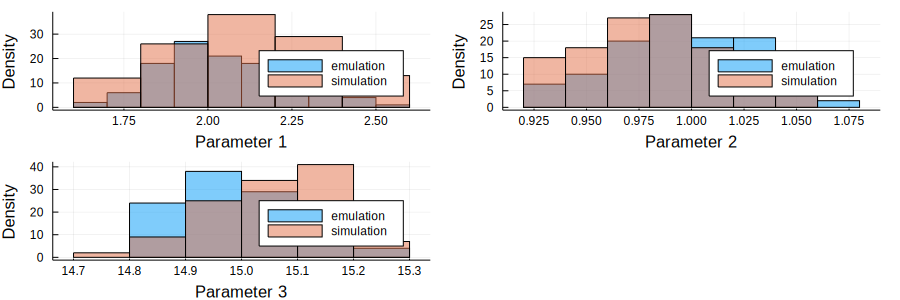

In [10]:
sim_pop = sim_abcsmc_res.population[end]
emu_pop = emu_abcsmc_res.population[end]
for idx in 1:length(plts)
    min_pop_len = min(size(emu_pop, 1), size(sim_pop, 1))
    plts[idx] = histogram([emu_pop[1:min_pop_len,idx] sim_pop[1:min_pop_len,idx]], 
        label=["emulation", "simulation"], fillalpha=0.5, xlabel="Parameter $idx", ylabel="Density")
end
plot(plts..., size=(900,300))
